Play around with the data: load an image, resize it, extract hog features, plot a window with the same size as the sliding window size of the hog feature extraction parameter to see how big it is.

resized dimension = (300, 300, 3)


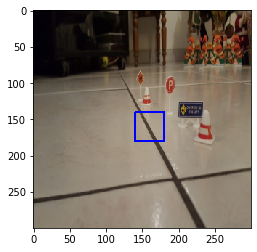

In [2]:
import numpy as np
import cv2 
import os
import matplotlib.pyplot as plt
%matplotlib inline


currentDirectory = os.getcwd()
path = currentDirectory + "/models/object_detection/data/images/train"
os.chdir(path)

# Load image
image = cv2.imread('photo_2019-12-19 18.59.23.jpeg')

#def preprocess_image():

# Resize Image
dim = (300,300)
resized = cv2.resize(image,dim,interpolation=cv2.INTER_AREA)
print("resized dimension =", resized.shape)
cv2.rectangle(resized,(140,140),(180,180),255,2)
plt.imshow(cv2.cvtColor(resized, cv2.COLOR_BGR2RGB))
plt.show()
#cv2.imshow('Resized image to dimension (300,300) sample with random bounding box of size (40,40)',resized)

# Hog transform
winSize = (40,40)
blockSize = (40,40)
blockStride = (10,10)
cellSize = (10,10)
nbins = 9
derivAperture = 1
winSigma = -1.
histogramNormType = 0
L2HysThreshold = 0.2
gammaCorrection = 1
nlevels = 64
useSignedGradients = True
hog = cv2.HOGDescriptor(winSize,blockSize,blockStride,cellSize,nbins,
                        derivAperture,winSigma,histogramNormType,
                        L2HysThreshold,gammaCorrection,nlevels, 
                        useSignedGradients)

winStride = (10,10)
descriptor = hog.compute(resized,winStride)

# final size hog descriptor : ((300/10 -3)*2*9)**2 ((300/10 -3) windows per row,2 cell by window, 9 hog features or nbin per cell)

Find the optimal hog sliding window which defines a bounding box around a ground truth object (not possible with the ground truth box because it has not the same size as the hog slinding window)

Column names are filename, width, height, class, xmin, ymin, xmax, ymax
Processed 187 lines.
[138, 227, 187, 251]


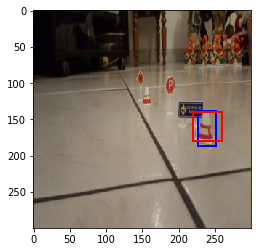

In [24]:
# import the necessary packages
import numpy as np
import cv2
import csv

def bb_intersection_over_union(boxA, boxB):
	# implementation borrowed with love from pylmage search blog <3
	# determine the (x, y)-coordinates of the intersection rectangle
	xA = max(boxA[0], boxB[0])
	yA = max(boxA[1], boxB[1])
	xB = min(boxA[2], boxB[2])
	yB = min(boxA[3], boxB[3])

	# compute the area of intersection rectangle
	interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)

	# compute the area of both the prediction and ground-truth
	# rectangles
	boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
	boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)

	# compute the intersection over union by taking the intersection
	# area and dividing it by the sum of prediction + ground-truth
	# areas - the interesection area
	iou = interArea / float(boxAArea + boxBArea - interArea)

	# return the intersection over union value
	return iou

	
# compute box coordinates from csv files

def convert_box(old_box, n_old_row, n_old_column, n_new_row, n_new_column):
	# convert label box to new image size 
  new_box_rmin = np.round(old_box[0]*n_new_row/n_old_row)
  new_box_cmin = np.round(old_box[1]*n_new_column/n_old_column)
  new_box_rmax = np.round(old_box[2]*n_new_row/n_old_row)
  new_box_cmax = np.round(old_box[3]*n_new_column/n_old_column)
  
  return [int(new_box_rmin), int(new_box_cmin), int(new_box_rmax), int(new_box_cmax)]

def rc_box_from_csv(filename):
	box_annotated = []
	with open(filename) as csv_file:
			csv_reader = csv.reader(csv_file, delimiter=',')
			line_count = 0
			for row in csv_reader:
					if line_count == 0:
						print(f'Column names are {", ".join(row)}')
						line_count += 1
					else:
						box_annotated.append(convert_box([int(row[5]),int(row[4]),int(row[7]),int(row[6])], 720, 1280, 300, 300))		
						line_count += 1
			print(f'Processed {line_count} lines.')
	return box_annotated
	
box_annotated = rc_box_from_csv('../../annotations/train_labels.csv')

print(box_annotated[0])

# Find overlapping hog cells with boxes from label and crop them
def find_max_iou(hogBox,box_annotated):
	index_hogBox= -1
	max_overlap = 0
	overlap = []
	for i in range(len(hogBox)):
		overlap.append(bb_intersection_over_union(hogBox[i], box_annotated))
		if bb_intersection_over_union(hogBox[i], box_annotated)>max_overlap:
			max_overlap = bb_intersection_over_union(hogBox[i], box_annotated)
			index_hogBox = i
	return index_hogBox, max_overlap, overlap

# to test:
# Compute hog cell boxes
hogBox = []
for i in range(int(np.sqrt(len(descriptor)/9)/4)):
	for j in range(int(np.sqrt(len(descriptor)/9)/4)):
		# [row_min, col_min, row_max, col_max]
		hogBox.append([i*winStride[0], j*winStride[0], i*winStride[0] + 40, j*winStride[0] + 40])

resized = cv2.resize(image,dim,interpolation=cv2.INTER_AREA)
[index_hogBox, max_overlap, overlap] = find_max_iou(hogBox,box_annotated[0])
cv2.rectangle(resized,(box_annotated[0][1],box_annotated[0][0]),(box_annotated[0][3],box_annotated[0][2]),255,2)
cv2.rectangle(resized,(hogBox[index_hogBox][1],hogBox[index_hogBox][0]),
             (hogBox[index_hogBox][3],hogBox[index_hogBox][2]),(0,0,255),2)

plt.imshow(cv2.cvtColor(resized, cv2.COLOR_BGR2RGB))
plt.show()

#print(hogBox)

# Make train set with examples of windows with an object inside as positive examples and windows without any object inside as negative examples.

In [19]:
import numpy as np
import cv2
import csv
import itertools
import random

# Define these cells as the object that is in the box, the other boxes are none type object
# decision : max overlapping is ground truth, non-overlapping are others
# Compute hog cell boxes
hogBox = []
for i in range(int(np.sqrt(len(descriptor)/9)/4)):
	for j in range(int(np.sqrt(len(descriptor)/9)/4)):
		# [row_min, col_min, row_max, col_max]
		hogBox.append([i*winStride[0], j*winStride[0], i*winStride[0] + 40, j*winStride[0] + 40])


def make_dataset_hog(filename, hogBox, training_state):
  train_set = []
  train_labels = []
  old_picture = 'None'

  # Hog transform parameters
  winSize = (40,40)
  blockSize = (40,40)
  blockStride = (10,10)
  cellSize = (10,10)
  nbins = 9
  derivAperture = 1
  winSigma = -1.
  histogramNormType = 0
  L2HysThreshold = 0.2
  gammaCorrection = 1
  nlevels = 64
  useSignedGradients = True
  hog = cv2.HOGDescriptor(winSize,blockSize,blockStride,cellSize,nbins,
                          derivAperture,winSigma,histogramNormType,
                          L2HysThreshold,gammaCorrection,nlevels, 
                          useSignedGradients)

  winStride = (10,10)

  with open(filename) as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    for row in csv_reader:
        if line_count == 0:
            print(f'Column names are {", ".join(row)}')
            line_count += 1
        else:

          picture = row[0]		
          if picture == old_picture :
            # find overlap of object bounding box hog box
            box_annotated = convert_box([int(row[5]),int(row[4]),int(row[7]),int(row[6])], 720, 1280, 300, 300)
            [index_hogBox, max_overlap, overlap] = find_max_iou(hogBox,box_annotated)
            # crop hog features window
            crop_hog_window = hog_descriptor[index_hogBox*9*16:(index_hogBox+1)*9*16] 
            # save hog window and label : 1 for object and 0 for not object
            train_set.append(np.array(list(itertools.chain.from_iterable(crop_hog_window)), np.float32)) 
            train_labels.append(1)

            overlap_global += overlap
            old_picture = picture

          else :
            if line_count>1 and training_state == True:
            # randomly crop some counter examples from non overlapping windows
              for i in range(10):
                non_overlapping_box = random.choice([i for i, e in enumerate(overlap_global) if e == 0])
                crop_hog_window = hog_descriptor[non_overlapping_box *9*16:(non_overlapping_box +1)*9*16] 
                # save hog window and label: 1 for object and 0 for not object
                train_set.append(np.array(list(itertools.chain.from_iterable(crop_hog_window)), np.float32)) 
                train_labels.append(0)
            
          
            # open new image and resize it
            img = cv2.imread(picture)
            dim = (300,300)
            resized = cv2.resize(img,dim,interpolation=cv2.INTER_AREA)

            # find overlap of object bounding box hog box
            box_annotated = convert_box([int(row[5]),int(row[4]),int(row[7]),int(row[6])], 720, 1280, 300, 300)
            [index_hogBox, max_overlap, overlap] = find_max_iou(hogBox,box_annotated)
            # compute hog features
            hog_descriptor = hog.compute(resized,winStride)
            # crop hog window
            crop_hog_window = hog_descriptor[index_hogBox*9*16:(index_hogBox+1)*9*16] 
            # save hog window and label: 1 for object and 0 for not object
            train_set.append(np.array(list(itertools.chain.from_iterable(crop_hog_window)), np.float32)) 
            train_labels.append(1)

            overlap_global= overlap
            old_picure = picture

          line_count += 1
  print(f'Processed {line_count} lines.')

  trainingDataMat = np.array(train_set, np.float32)
  trainingLabel = np.array(train_labels, np.int32)
  return trainingDataMat, trainingLabel


# Save images into a training set along with their corresponding label

%cd ../train
training_state = True
[trainingDataMat, trainingLabel] = make_dataset_hog('../../annotations/train_labels.csv', hogBox, training_state)


%cd ../test
#training_state = False
#[testingDataMat, testingLabel] = make_dataset_hog('../../annotations/test_labels.csv', hogBox, training_state)
# Same for testing set images

#!cat ../../annotations/test_labels.csv


/Users/matt/Workspace/picar/code/models/object_detection/data/images/train
Column names are filename, width, height, class, xmin, ymin, xmax, ymax
Processed 187 lines.
/Users/matt/Workspace/picar/code/models/object_detection/data/images/test


# Train a SVM classifier to detect multiple traffic sign in a picture and display a result on a test image. We see that we can have multiple windows that detect the same object.

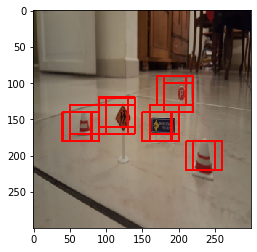

In [20]:
# Set up SVM for OpenCV 3
svm = cv2.ml.SVM_create()
# Set SVM type
svm.setType(cv2.ml.SVM_C_SVC)
# Set SVM Kernel to Radial Basis Function (RBF) 
svm.setKernel(cv2.ml.SVM_RBF)
# Set parameter C
svm.setC(1)
# Set parameter Gamma
svm.setGamma(10)
# Train SVM on training data  
svm.setTermCriteria((cv2.TERM_CRITERIA_COUNT, 100, 1.e-06))
svm.train(trainingDataMat, cv2.ml.ROW_SAMPLE, trainingLabel )
#svm.trainAuto() # can be svm.trainAuto(td) to find best C and gamma values
 
# Save trained model 
#svm.save("digits_svm_model.yml");

# Test on a held out test set
# open new image and resize it
img_test = cv2.imread('photo_2019-12-19 18.59.47.jpeg')
dim = (300,300)
resized = cv2.resize(img_test,dim,interpolation=cv2.INTER_AREA)

# compute hog features
hog_descriptor = hog.compute(resized,winStride)

index_detect = []
for index_hogBox in range(27*27):
  # crop hog window
  crop_hog_window = hog_descriptor[index_hogBox*9*16:(index_hogBox+1)*9*16] 
  sample_data = np.array([list(itertools.chain.from_iterable(crop_hog_window))], np.float32)
  detect_test = svm.predict(sample_data)
  #print(detect_test[1])
  if detect_test[1] == 1.0:
    index_detect.append(index_hogBox)

for ind in range(len(index_detect)):
  cv2.rectangle(resized,(hogBox[index_detect[ind]][1],hogBox[index_detect[ind]][0]),
             (hogBox[index_detect[ind]][3],hogBox[index_detect[ind]][2]),(0,0,255),2)

#img_testDataMat = np.array(test_set, np.float32)
#testResponse = svm.predict(sample_data)

plt.imshow(cv2.cvtColor(resized, cv2.COLOR_BGR2RGB))
plt.show()

# Group bounding box that detects the same object and test the object detection on the test set

photo_2019-12-19 18.59.51.jpeg


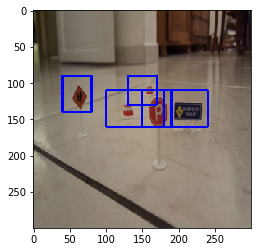

photo_2019-12-19 18.59.47.jpeg


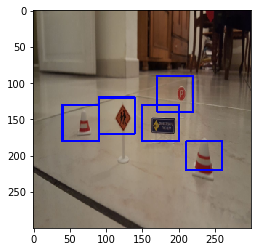

photo_2019-12-19 18.59.50 (1).jpeg


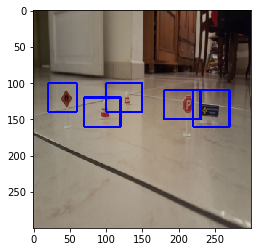

photo_2019-12-19 18.59.46.jpeg


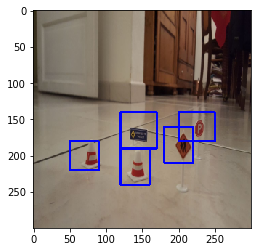

photo_2019-12-19 18.59.50.jpeg


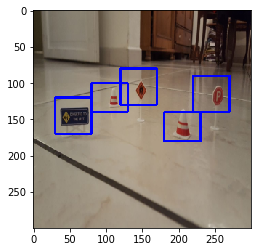

photo_2019-12-19 18.59.54.jpeg


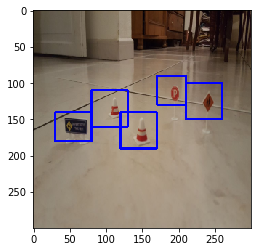

photo_2019-12-19 18.59.53.jpeg


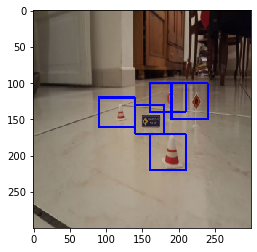

photo_2019-12-19 18.59.49.jpeg


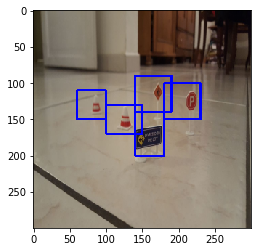

photo_2019-12-19 18.59.48.jpeg


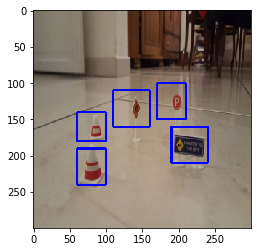

photo_2019-12-19 18.59.52.jpeg


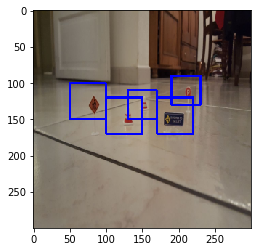

In [21]:
import os

def group_overlapping_boxes(hogBox,index_detect):

  group_box_tmp = []
  for ind in range(len(index_detect)):
    group_box_tmp.append(hogBox[index_detect[ind]])

  change = 1
  while change == 1:
    change = None
    for ind in range(len(index_detect)):
      for ind2 in range(len(index_detect)):
        if ind != ind2 and group_box_tmp[ind2]!= None and group_box_tmp[ind]!= None:
          # Compute intersection over union
          iou = bb_intersection_over_union(hogBox[index_detect[ind]], hogBox[index_detect[ind2]])
          if iou > 0.3:
            a = min([group_box_tmp[ind][0], hogBox[index_detect[ind2]][0]])
            b = min([group_box_tmp[ind][1], hogBox[index_detect[ind2]][1]])
            c = max([group_box_tmp[ind][2], hogBox[index_detect[ind2]][2]])
            d = max([group_box_tmp[ind][3], hogBox[index_detect[ind2]][3]])
            
            
            group_box_tmp[ind2] = None
            group_box_tmp[ind] = [a,b,c,d]
            change = 1
    group_box = [item for item in group_box_tmp if item != None]
  return group_box

filelist=os.listdir('.')
for im_path in filelist[:]: # filelist[:] makes a copy of filelist.
  if not(im_path.endswith(".jpeg")):
      filelist.remove(im_path)
  else:
    print(im_path)
    #img_test = cv2.imread('photo_2019-12-19 18.59.50 (1).jpeg')
    img_test = cv2.imread(im_path)
    dim = (300,300)
    resized = cv2.resize(img_test,dim,interpolation=cv2.INTER_AREA)

    # compute hog features
    hog_descriptor = hog.compute(resized,winStride)

    index_detect = []
    for index_hogBox in range(27*27):
      # crop hog window
      crop_hog_window = hog_descriptor[index_hogBox*9*16:(index_hogBox+1)*9*16] 
      sample_data = np.array([list(itertools.chain.from_iterable(crop_hog_window))], np.float32)
      detect_test = svm.predict(sample_data)
      #print(detect_test[1])
      if detect_test[1] == 1.0:
        index_detect.append(index_hogBox)

    group_boxes = group_overlapping_boxes(hogBox,index_detect)

    for ind in range(len(group_boxes)):
      cv2.rectangle(resized,(group_boxes[ind][1],group_boxes[ind][0]),
                    (group_boxes[ind][3], group_boxes[ind][2]),255,2)

    plt.imshow(cv2.cvtColor(resized, cv2.COLOR_BGR2RGB))
    plt.show()